# Step 1.0 SETUP

In [5]:
#STEP 1.0 SETUP
#Initializig the schema and table
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.appName("INFS3208").getOrCreate()

game = spark.read.format("csv").option("header","true").load("hdfs://namenode:9000/proj/vgsales.csv")



In [20]:
game.show()

+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform|            Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing|            Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports|            Nintendo|   15.75|   11.01|    3.28|       2.96|          33|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing|            Nintendo|   11.27|    8.89|   10.22|  

In [21]:
# Showing a better looking table for ease of visibility
game.toPandas()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,Kemco,0.01,0,0,0,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003,Shooter,Infogrames,0.01,0,0,0,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,Activision,0,0,0,0,0.01
16596,16599,Know How 2,DS,2010,Puzzle,7G//AMES,0,0.01,0,0,0.01


# STEP 2.0 DATA EXPLORATION & PREPROCESSING

In [22]:
#STEP 2.0 DATA EXPLORATION & PREPROCESSING
# Duplicate Checking and drop if any
print("Total columns: " + str(game.count()))
removeDuplicate = game.dropDuplicates()
print("Total columns (after duplicate removal): " + str(removeDuplicate.count()))
# Null checking and drop if any
dropNull = game.dropna()
print("Total columns (after null removal): " + str(removeDuplicate.count()))

Total columns: 16598
Total columns (after duplicate removal): 16598
Total columns (after null removal): 16598


In [23]:
#Registering temp table to analyze the whole data
game.registerTempTable("VG")

In [24]:
#Counting the total of genre and checking the highest number of Publisher and Platform
spark.sql("SELECT COUNT(*) AS GENRE_COUNT, GENRE FROM VG GROUP BY GENRE ORDER BY GENRE DESC").show()
spark.sql("SELECT COUNT(*) AS PUBLISHER_COUNT, PUBLISHER FROM VG GROUP BY PUBLISHER ORDER BY PUBLISHER_COUNT DESC").show()
spark.sql("SELECT COUNT(*) AS PLATFORM_COUNT, PLATFORM FROM VG GROUP BY PLATFORM ORDER BY PLATFORM_COUNT DESC").show()

+-----------+------------+
|GENRE_COUNT|       GENRE|
+-----------+------------+
|        681|    Strategy|
|       2346|      Sports|
|        867|  Simulation|
|       1310|     Shooter|
|       1488|Role-Playing|
|       1249|      Racing|
|        582|      Puzzle|
|        886|    Platform|
|       1739|        Misc|
|        848|    Fighting|
|       1286|   Adventure|
|       3316|      Action|
+-----------+------------+

+---------------+--------------------+
|PUBLISHER_COUNT|           PUBLISHER|
+---------------+--------------------+
|           1351|     Electronic Arts|
|            975|          Activision|
|            932|  Namco Bandai Games|
|            921|             Ubisoft|
|            832|Konami Digital En...|
|            715|                 THQ|
|            703|            Nintendo|
|            683|Sony Computer Ent...|
|            639|                Sega|
|            413|Take-Two Interactive|
|            381|              Capcom|
|            363|    

In [25]:
#Checking Min and Max year
spark.sql("SELECT MIN(YEAR) AS MIN_YEAR FROM VG").show()
spark.sql("SELECT MAX(YEAR) AS MAX_YEAR FROM VG").show()

+--------+
|MIN_YEAR|
+--------+
|    1980|
+--------+

+--------+
|MAX_YEAR|
+--------+
|     N/A|
+--------+



In [68]:
#Removing N/A Year
gameyear = game.where(col('Year') != "N/A")
gameyear.registerTempTable("VGY")

spark.sql("SELECT MAX(YEAR) AS MAX_YEAR FROM VGY").show()

gameyear.printSchema()

+--------+
|MAX_YEAR|
+--------+
|    2020|
+--------+

root
 |-- Rank: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- NA_Sales: string (nullable = true)
 |-- EU_Sales: string (nullable = true)
 |-- JP_Sales: string (nullable = true)
 |-- Other_Sales: string (nullable = true)
 |-- Global_Sales: string (nullable = true)



In [69]:
#Changing the schema to actually suits the data type
gameschema = spark.sql("SELECT INT(RANK), STRING(NAME), STRING(PLATFORM), INT(YEAR), STRING(GENRE), STRING(PUBLISHER), FLOAT(NA_SALES), FLOAT(EU_SALES), FLOAT(JP_SALES), FLOAT(OTHER_SALES), FLOAT(GLOBAL_SALES) from VGY")
gameschema.printSchema()
gameschema.registerTempTable("VGS")

root
 |-- RANK: integer (nullable = true)
 |-- NAME: string (nullable = true)
 |-- PLATFORM: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- GENRE: string (nullable = true)
 |-- PUBLISHER: string (nullable = true)
 |-- NA_SALES: float (nullable = true)
 |-- EU_SALES: float (nullable = true)
 |-- JP_SALES: float (nullable = true)
 |-- OTHER_SALES: float (nullable = true)
 |-- GLOBAL_SALES: float (nullable = true)



# STEP 3.1 GAME PLATFORM FOCUSED

In [72]:
#STEP 3.1 PLATFORM ANALYSIS
#Checking top 5 platform sales in different countries and global
spark.sql("SELECT PLATFORM, ROUND(SUM(NA_SALES),2) AS SUM_NA_SALES FROM VGS GROUP BY PLATFORM ORDER BY SUM_NA_SALES DESC").show(5)
spark.sql("SELECT PLATFORM, ROUND(SUM(EU_SALES),2) AS SUM_EU_SALES FROM VGS GROUP BY PLATFORM ORDER BY SUM_EU_SALES DESC").show(5)
spark.sql("SELECT PLATFORM, ROUND(SUM(JP_SALES),2) AS SUM_JP_SALES FROM VGS GROUP BY PLATFORM ORDER BY SUM_JP_SALES DESC").show(5)
spark.sql("SELECT PLATFORM, ROUND(SUM(OTHER_SALES),2) AS SUM_OTHER_SALES FROM VGS GROUP BY PLATFORM ORDER BY SUM_OTHER_SALES DESC").show(5)
spark.sql("SELECT PLATFORM, ROUND(SUM(GLOBAL_SALES),2) AS SUM_GLOBAL_SALES FROM VGS GROUP BY PLATFORM ORDER BY SUM_GLOBAL_SALES DESC").show(5)

+--------+------------+
|PLATFORM|SUM_NA_SALES|
+--------+------------+
|    X360|      594.33|
|     PS2|      572.92|
|     Wii|      497.37|
|     PS3|       388.9|
|      DS|      388.56|
+--------+------------+
only showing top 5 rows

+--------+------------+
|PLATFORM|SUM_EU_SALES|
+--------+------------+
|     PS3|      340.47|
|     PS2|      332.63|
|    X360|      278.01|
|     Wii|      264.35|
|      PS|      212.38|
+--------+------------+
only showing top 5 rows

+--------+------------+
|PLATFORM|SUM_JP_SALES|
+--------+------------+
|      DS|      175.02|
|      PS|      139.78|
|     PS2|      137.54|
|    SNES|      116.55|
|     NES|       98.65|
+--------+------------+
only showing top 5 rows

+--------+---------------+
|PLATFORM|SUM_OTHER_SALES|
+--------+---------------+
|     PS2|         190.47|
|     PS3|         140.81|
|    X360|          84.67|
|     Wii|           79.2|
|      DS|          60.29|
+--------+---------------+
only showing top 5 rows

+--------

<AxesSubplot:title={'center':'DS Sales'}, xlabel='YEAR', ylabel='Sales(in USD billion)'>

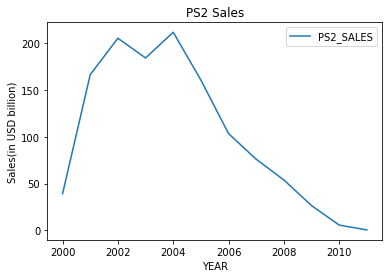

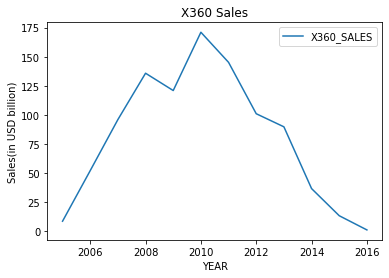

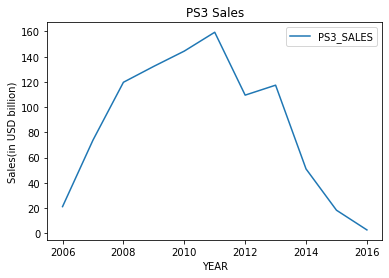

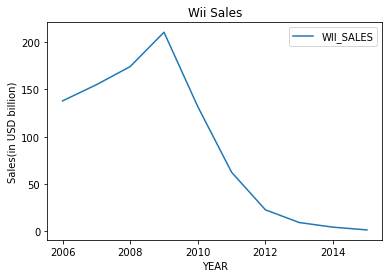

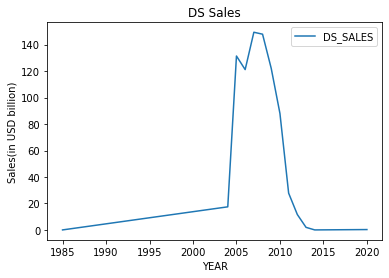

In [73]:
#Showing the graph of the top 5 global sales
ps2sales = spark.sql("SELECT PLATFORM, YEAR, SUM(GLOBAL_SALES) AS PS2_SALES FROM VGS WHERE PLATFORM = 'PS2' GROUP BY PLATFORM, YEAR ORDER BY YEAR ASC").toPandas()
ps2sales.plot(x = 'YEAR', y = 'PS2_SALES', title = 'PS2 Sales', ylabel = "Sales(in USD billion)")

x360sales = spark.sql("SELECT PLATFORM, YEAR, SUM(GLOBAL_SALES) AS X360_SALES FROM VGS WHERE PLATFORM = 'X360' GROUP BY PLATFORM, YEAR ORDER BY YEAR ASC").toPandas()
x360sales.plot(x = 'YEAR', y = 'X360_SALES', title = 'X360 Sales', ylabel = "Sales(in USD billion)")

ps3sales = spark.sql("SELECT PLATFORM, YEAR, SUM(GLOBAL_SALES) AS PS3_SALES FROM VGS WHERE PLATFORM = 'PS3' GROUP BY PLATFORM, YEAR ORDER BY YEAR ASC").toPandas()
ps3sales.plot(x = 'YEAR', y = 'PS3_SALES', title = 'PS3 Sales', ylabel = "Sales(in USD billion)")

wiisales = spark.sql("SELECT PLATFORM, YEAR, SUM(GLOBAL_SALES) AS WII_SALES FROM VGS WHERE PLATFORM = 'Wii' GROUP BY PLATFORM, YEAR ORDER BY YEAR ASC").toPandas()
wiisales.plot(x = 'YEAR', y = 'WII_SALES', title = 'Wii Sales', ylabel = "Sales(in USD billion)")

dssales = spark.sql("SELECT PLATFORM, YEAR, SUM(GLOBAL_SALES) AS DS_SALES FROM VGS WHERE PLATFORM = 'DS' GROUP BY PLATFORM, YEAR ORDER BY YEAR ASC").toPandas()
dssales.plot(x = 'YEAR', y = 'DS_SALES', title = 'DS Sales', ylabel = "Sales(in USD billion)")

In [81]:
#Checking the minimum year of DS year
spark.sql('''SELECT NAME, PLATFORM, YEAR
FROM VGS, (SELECT MIN(YEAR) AS MIN_YEAR_DS
FROM VGS
WHERE PLATFORM = "DS")
WHERE YEAR = MIN_YEAR_DS
AND PLATFORM = "DS"
''').toPandas()

,NAME,PLATFORM,YEAR
0,Strongest Tokyo University Shogi DS,DS,1985


Note: DS has not existed yet back in 1985 and the game listed above was adaptation of an old game to Nintendo DS which was released in 2004

<AxesSubplot:title={'center':'DS Sales'}, xlabel='YEAR', ylabel='Sales(in USD billion)'>

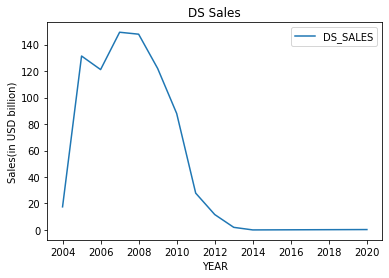

In [82]:
#Removing year 1985 to see the graph of Nintendo DS games sales
dssales = spark.sql("SELECT PLATFORM, YEAR, SUM(GLOBAL_SALES) AS DS_SALES FROM VGS WHERE PLATFORM = 'DS' AND YEAR != 1985 GROUP BY PLATFORM, YEAR ORDER BY YEAR ASC").toPandas()
dssales.plot(x = 'YEAR', y = 'DS_SALES', title = 'DS Sales', ylabel = "Sales(in USD billion)")

In [83]:
#Checking the percentage of sales contribution of top 5 platform games to the total sales of all of games
percentage = spark.sql("""SELECT ROUND((PS2_SALES/TOTAL_SALES)*100,2) AS PS2_PERCENTAGE,
ROUND((X360_SALES/TOTAL_SALES)*100,2) AS X360_PERCENTAGE,
ROUND((PS3_SALES/TOTAL_SALES)*100,2) AS PS3_PERCENTAGE,
ROUND((WII_SALES/TOTAL_SALES)*100,2) AS WII_PERCENTAGE,
ROUND((DS_SALES/TOTAL_SALES)*100,2) AS DS_PERCENTAGE
FROM
(SELECT SUM(GLOBAL_SALES) AS TOTAL_SALES FROM VGS),
(SELECT PLATFORM, SUM(GLOBAL_SALES) AS PS2_SALES FROM VGS WHERE PLATFORM = 'PS2' GROUP BY PLATFORM),
(SELECT PLATFORM, SUM(GLOBAL_SALES) AS X360_SALES FROM VGS WHERE PLATFORM = 'X360' GROUP BY PLATFORM),
(SELECT PLATFORM, SUM(GLOBAL_SALES) AS PS3_SALES FROM VGS WHERE PLATFORM = 'PS3' GROUP BY PLATFORM),
(SELECT PLATFORM, SUM(GLOBAL_SALES) AS WII_SALES FROM VGS WHERE PLATFORM = 'Wii' GROUP BY PLATFORM),
(SELECT PLATFORM, SUM(GLOBAL_SALES) AS DS_SALES FROM VGS WHERE PLATFORM = 'DS' GROUP BY PLATFORM)
""")
percentage.show()

+--------------+---------------+--------------+--------------+-------------+
|PS2_PERCENTAGE|X360_PERCENTAGE|PS3_PERCENTAGE|WII_PERCENTAGE|DS_PERCENTAGE|
+--------------+---------------+--------------+--------------+-------------+
|         13.98|          10.99|         10.76|         10.31|         9.28|
+--------------+---------------+--------------+--------------+-------------+



Conclusion:
- The selected consoles has more sales after about 2-4 years after their release
- Playstation consoles, PS2 and PS3, have the highest sales compared to other consoles, which then followed by Nintendo consoles, Wii and DS

# STEP 3.2 GAME PUBLISHER FOCUSED

<AxesSubplot:title={'center':'Publisher Total Sales'}, xlabel='PUBLISHER', ylabel='Sales(in USD billion)'>

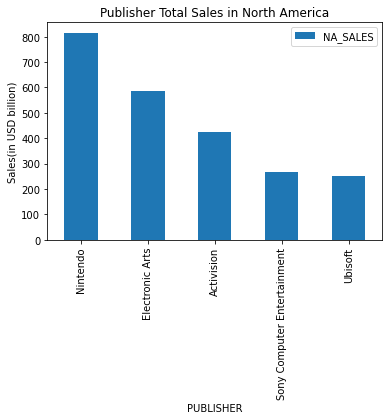

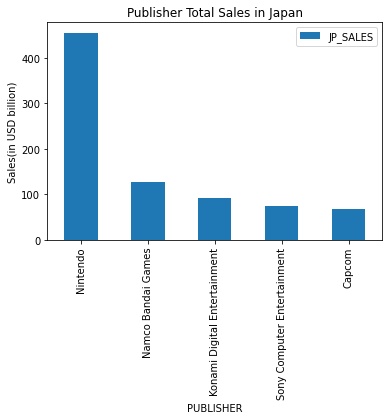

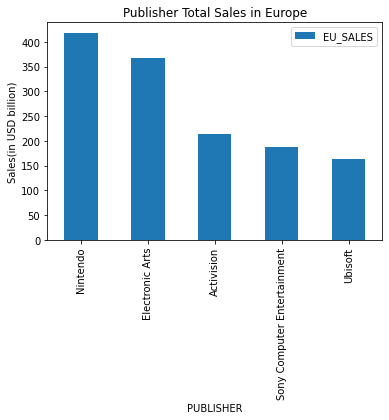

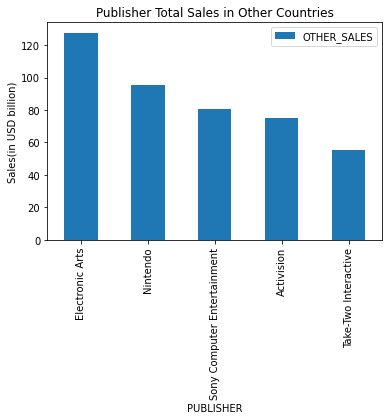

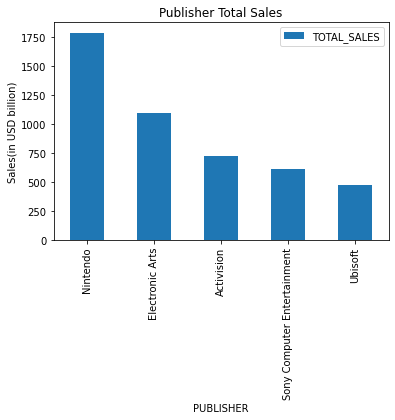

In [84]:
# STEP 3.2 PUBLISHER ANALYSIS
#Looking at top 5 consoles in different countries and global
popularPub = spark.sql("""SELECT PUBLISHER, ROUND(SUM(GLOBAL_SALES),2) AS TOTAL_SALES
FROM VGS
GROUP BY PUBLISHER
ORDER BY TOTAL_SALES DESC
LIMIT 5
""").toPandas()

popularPubNA = spark.sql("""SELECT PUBLISHER, ROUND(SUM(NA_SALES),2) AS NA_SALES
FROM VGS
GROUP BY PUBLISHER
ORDER BY NA_SALES DESC
LIMIT 5
""").toPandas()

popularPubJP = spark.sql("""SELECT PUBLISHER, ROUND(SUM(JP_SALES),2) AS JP_SALES
FROM VGS
GROUP BY PUBLISHER
ORDER BY JP_SALES DESC
LIMIT 5
""").toPandas()

popularPubEU = spark.sql("""SELECT PUBLISHER, ROUND(SUM(EU_SALES),2) AS EU_SALES
FROM VGS
GROUP BY PUBLISHER
ORDER BY EU_SALES DESC
LIMIT 5
""").toPandas()

popularPubOT = spark.sql("""SELECT PUBLISHER, ROUND(SUM(OTHER_SALES),2) AS OTHER_SALES
FROM VGS
GROUP BY PUBLISHER
ORDER BY OTHER_SALES DESC
LIMIT 5
""").toPandas()


popularPubNA.plot(kind = 'bar', x = 'PUBLISHER', y = 'NA_SALES', title = 'Publisher Total Sales in North America', ylabel = "Sales(in USD billion)")
popularPubJP.plot(kind = 'bar', x = 'PUBLISHER', y = 'JP_SALES', title = 'Publisher Total Sales in Japan', ylabel = "Sales(in USD billion)")
popularPubEU.plot(kind = 'bar', x = 'PUBLISHER', y = 'EU_SALES', title = 'Publisher Total Sales in Europe', ylabel = "Sales(in USD billion)")
popularPubOT.plot(kind = 'bar', x = 'PUBLISHER', y = 'OTHER_SALES', title = 'Publisher Total Sales in Other Countries', ylabel = "Sales(in USD billion)")
popularPub.plot(kind = 'bar', x = 'PUBLISHER', y = 'TOTAL_SALES', title = 'Publisher Total Sales', ylabel = "Sales(in USD billion)")

<AxesSubplot:title={'center':'Ubisoft Total Sales'}, xlabel='YEAR', ylabel='Sales(in USD billion)'>

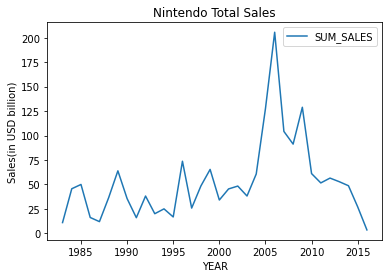

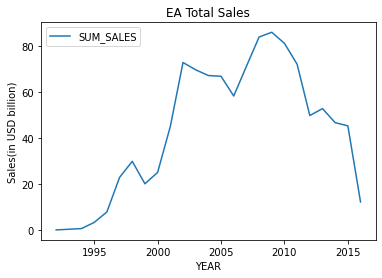

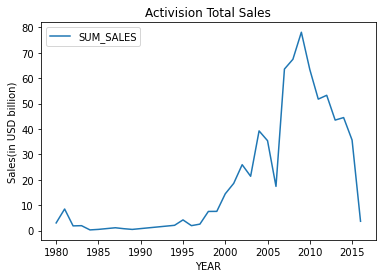

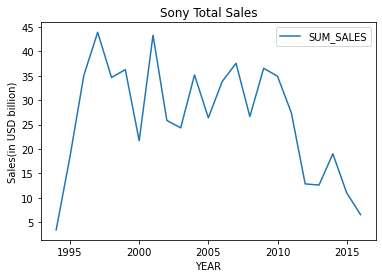

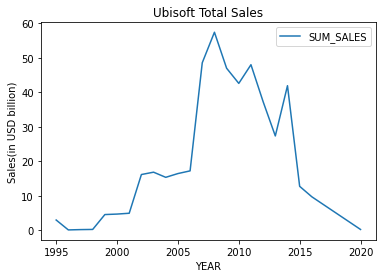

In [93]:
# Looking at the sales of the top 5 publisher every year
nintendosales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE PUBLISHER = 'Nintendo'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

easales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE PUBLISHER = 'Electronic Arts'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

activisionsales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE PUBLISHER = 'Activision'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

sonysales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE PUBLISHER = 'Sony Computer Entertainment'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

ubisoftsales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE PUBLISHER = 'Ubisoft'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

nintendosales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'Nintendo Total Sales', ylabel = "Sales(in USD billion)")
easales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'EA Total Sales', ylabel = "Sales(in USD billion)")
activisionsales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'Activision Total Sales', ylabel = "Sales(in USD billion)")
sonysales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'Sony Total Sales', ylabel = "Sales(in USD billion)")
ubisoftsales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'Ubisoft Total Sales', ylabel = "Sales(in USD billion)")

In [85]:
# Selecting top 5 publisher from global and check the number of game genres they have released
spark.sql("""SELECT PUBLISHER, GENRE, COUNT(*) AS GENRE_COUNT
FROM VGS
WHERE PUBLISHER = "Nintendo"
GROUP BY PUBLISHER, GENRE
ORDER BY GENRE_COUNT DESC
""").show()

spark.sql("""SELECT PUBLISHER, GENRE, COUNT(*) AS GENRE_COUNT
FROM VGS
WHERE PUBLISHER = "Electronic Arts"
GROUP BY PUBLISHER, GENRE
ORDER BY GENRE_COUNT DESC
""").show()

spark.sql("""SELECT PUBLISHER, GENRE, COUNT(*) AS GENRE_COUNT
FROM VGS
WHERE PUBLISHER = "Activision"
GROUP BY PUBLISHER, GENRE
ORDER BY GENRE_COUNT DESC
""").show()

spark.sql("""SELECT PUBLISHER, GENRE, COUNT(*) AS GENRE_COUNT
FROM VGS
WHERE PUBLISHER = "Sony Computer Entertainment"
GROUP BY PUBLISHER, GENRE
ORDER BY GENRE_COUNT DESC
""").show()

spark.sql("""SELECT PUBLISHER, GENRE, COUNT(*) AS GENRE_COUNT
FROM VGS
WHERE PUBLISHER = "Ubisoft"
GROUP BY PUBLISHER, GENRE
ORDER BY GENRE_COUNT DESC
""").show()

+---------+------------+-----------+
|PUBLISHER|       GENRE|GENRE_COUNT|
+---------+------------+-----------+
| Nintendo|    Platform|        111|
| Nintendo|Role-Playing|        105|
| Nintendo|        Misc|        100|
| Nintendo|      Action|         78|
| Nintendo|      Puzzle|         74|
| Nintendo|      Sports|         55|
| Nintendo|      Racing|         37|
| Nintendo|   Adventure|         35|
| Nintendo|    Strategy|         31|
| Nintendo|  Simulation|         28|
| Nintendo|     Shooter|         24|
| Nintendo|    Fighting|         18|
+---------+------------+-----------+

+---------------+------------+-----------+
|      PUBLISHER|       GENRE|GENRE_COUNT|
+---------------+------------+-----------+
|Electronic Arts|      Sports|        554|
|Electronic Arts|      Action|        182|
|Electronic Arts|      Racing|        159|
|Electronic Arts|     Shooter|        139|
|Electronic Arts|  Simulation|        116|
|Electronic Arts|        Misc|         43|
|Electronic Arts|   

In [86]:
#Looking at the top game sales of those top 5 publishers
spark.sql('''SELECT RANK, NAME, YEAR, GENRE, PUBLISHER, GLOBAL_SALES
FROM VGS,(SELECT MAX(GLOBAL_SALES) AS MAX_SALES
FROM VGS
WHERE PUBLISHER = "Nintendo")
WHERE GLOBAL_SALES = MAX_SALES
AND PUBLISHER = "Nintendo"
''').show()

spark.sql('''SELECT RANK, NAME, YEAR, GENRE, PUBLISHER, GLOBAL_SALES
FROM VGS,(SELECT MAX(GLOBAL_SALES) AS MAX_SALES
FROM VGS
WHERE PUBLISHER = "Electronic Arts")
WHERE GLOBAL_SALES = MAX_SALES
AND PUBLISHER = "Electronic Arts"
''').show()

spark.sql('''SELECT RANK, NAME, YEAR, GENRE, PUBLISHER, CAST(GLOBAL_SALES AS FLOAT)
FROM VGS,(SELECT MAX(GLOBAL_SALES) AS MAX_SALES
FROM VGS
WHERE PUBLISHER = "Activision")
WHERE GLOBAL_SALES = MAX_SALES
AND PUBLISHER = "Activision"
''').show()

spark.sql('''SELECT RANK, NAME, YEAR, GENRE, PUBLISHER, GLOBAL_SALES
FROM VGS,(SELECT MAX(GLOBAL_SALES) AS MAX_SALES
FROM VGS
WHERE PUBLISHER = "Sony Computer Entertainment")
WHERE GLOBAL_SALES = MAX_SALES
AND PUBLISHER = "Sony Computer Entertainment"
''').show()

spark.sql('''SELECT RANK, NAME, YEAR, GENRE, PUBLISHER, GLOBAL_SALES
FROM VGS,(SELECT MAX(GLOBAL_SALES) AS MAX_SALES
FROM VGS
WHERE PUBLISHER = "Ubisoft")
WHERE GLOBAL_SALES = MAX_SALES
AND PUBLISHER = "Ubisoft"
''').show()

+----+----------+----+------+---------+------------+
|RANK|      NAME|YEAR| GENRE|PUBLISHER|GLOBAL_SALES|
+----+----------+----+------+---------+------------+
|   1|Wii Sports|2006|Sports| Nintendo|       82.74|
+----+----------+----+------+---------+------------+

+----+-------+----+------+---------------+------------+
|RANK|   NAME|YEAR| GENRE|      PUBLISHER|GLOBAL_SALES|
+----+-------+----+------+---------------+------------+
|  78|FIFA 16|2015|Sports|Electronic Arts|        8.49|
+----+-------+----+------+---------------+------------+

+----+--------------------+----+-------+----------+------------+
|RANK|                NAME|YEAR|  GENRE| PUBLISHER|GLOBAL_SALES|
+----+--------------------+----+-------+----------+------------+
|  30|Call of Duty: Mod...|2011|Shooter|Activision|       14.76|
+----+--------------------+----+-------+----------+------------+

+----+--------------------+----+------+--------------------+------------+
|RANK|                NAME|YEAR| GENRE|           PUB

Conclusion:
- The top game sales made by publisher does not mean that genre is the most genre that the publisher has released. For example, Ubisoft has mostly released Action games, but its top sales were made by Just Dance 3, which was not an Action games.
- In Japan, most of the sales were directed to Nintendo. While Nintendo has also made it to the top in other countries, the gap between top 1 and top 2 in Japan was more significant compared to other countries. In other words, it can be said that Nintendo games were more popular than games made by other publisher in Japan
- The fact that Nintendo is extremely popular in Japan and having more exclusive games might be the reason why it has the highest sales among all publishers

# STEP 3.3 GENRE ANALYSIS 

<AxesSubplot:title={'center':'Genre Total Sales'}, xlabel='GENRE', ylabel='Sales(in USD billion)'>

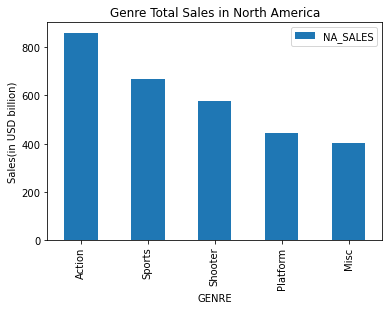

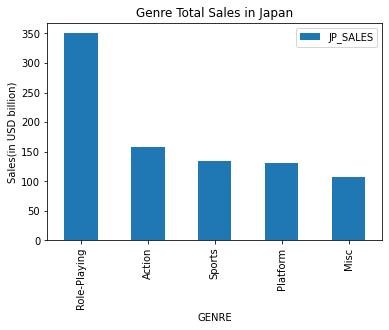

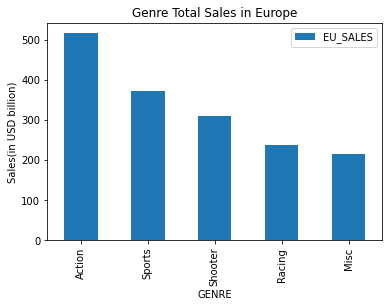

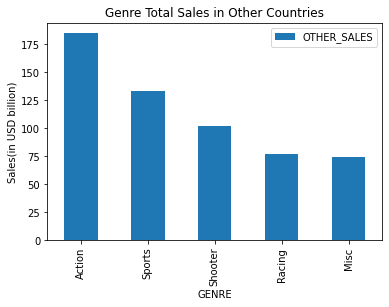

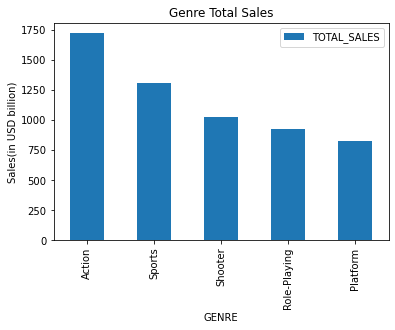

In [94]:
# STEP 3.3 GENRE ANALYSIS
# Analysing the popular genre in different countries and global
popularGenre = spark.sql("""SELECT GENRE, ROUND(SUM(GLOBAL_SALES),2) AS TOTAL_SALES
FROM VGS
GROUP BY GENRE
ORDER BY TOTAL_SALES DESC
LIMIT 5
""").toPandas()

popularGenreNA = spark.sql("""SELECT GENRE, ROUND(SUM(NA_SALES),2) AS NA_SALES
FROM VGS
GROUP BY GENRE
ORDER BY NA_SALES DESC
LIMIT 5
""").toPandas()

popularGenreJP = spark.sql("""SELECT GENRE, ROUND(SUM(JP_SALES),2) AS JP_SALES
FROM VGS
GROUP BY GENRE
ORDER BY JP_SALES DESC
LIMIT 5
""").toPandas()

popularGenreEU = spark.sql("""SELECT GENRE, ROUND(SUM(EU_SALES),2) AS EU_SALES
FROM VGS
GROUP BY GENRE
ORDER BY EU_SALES DESC
LIMIT 5
""").toPandas()

popularGenreOT = spark.sql("""SELECT GENRE, ROUND(SUM(OTHER_SALES),2) AS OTHER_SALES
FROM VGS
GROUP BY GENRE
ORDER BY OTHER_SALES DESC
LIMIT 5
""").toPandas()

popularGenreNA.plot(kind = 'bar', x = 'GENRE', y = 'NA_SALES', title = 'Genre Total Sales in North America', ylabel = "Sales(in USD billion)")
popularGenreJP.plot(kind = 'bar', x = 'GENRE', y = 'JP_SALES', title = 'Genre Total Sales in Japan', ylabel = "Sales(in USD billion)")
popularGenreEU.plot(kind = 'bar', x = 'GENRE', y = 'EU_SALES', title = 'Genre Total Sales in Europe', ylabel = "Sales(in USD billion)")
popularGenreOT.plot(kind = 'bar', x = 'GENRE', y = 'OTHER_SALES', title = 'Genre Total Sales in Other Countries', ylabel = "Sales(in USD billion)")
popularGenre.plot(kind = 'bar', x = 'GENRE', y = 'TOTAL_SALES', title = 'Genre Total Sales', ylabel = "Sales(in USD billion)")

<AxesSubplot:title={'center':'Platform Total Sales'}, xlabel='YEAR', ylabel='Sales(in USD billion)'>

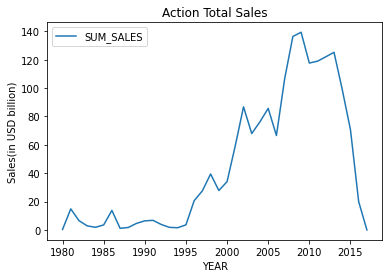

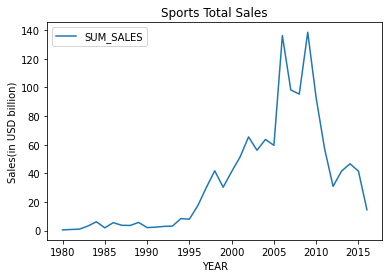

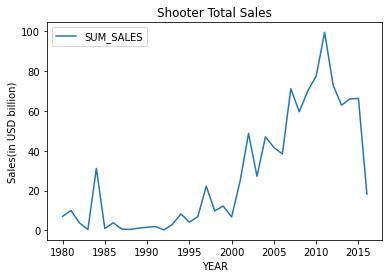

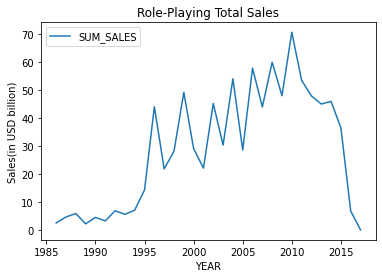

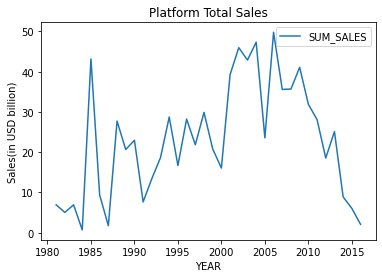

In [95]:
# Looking at the sales of the top 5 genres globally
actionsales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE GENRE = 'Action'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

sportssales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE GENRE = 'Sports'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

shootersales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE GENRE = 'Shooter'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

roleplayingsales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE GENRE = 'Role-Playing'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

platformsales = spark.sql('''SELECT YEAR, ROUND(SUM(GLOBAL_SALES),2) AS SUM_SALES
FROM VGS
WHERE GENRE = 'Platform'
GROUP BY YEAR
ORDER BY YEAR ASC
''').toPandas()

actionsales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'Action Total Sales', ylabel = "Sales(in USD billion)")
sportssales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'Sports Total Sales', ylabel = "Sales(in USD billion)")
shootersales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'Shooter Total Sales', ylabel = "Sales(in USD billion)")
roleplayingsales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'Role-Playing Total Sales', ylabel = "Sales(in USD billion)")
platformsales.plot(x = 'YEAR', y = 'SUM_SALES', title = 'Platform Total Sales', ylabel = "Sales(in USD billion)")

Conclusion: 
- The reason behind the popularity of Sports game could be caused by Electronic Arts releasing many sports game in different consoles (platforms), which will be analysed in the next section
- While other countries have Action as the genre with highest sales, Japan was the only country with Role-Playing as genre with the highest sales. This will also be analysed in the next section

# STEP 3.4 GAME ANALYSIS

In [97]:
# STEP 3.4 GAME ANALYSIS
# Looking at the most popular role-playing game in Japan
spark.sql("""SELECT RANK, NAME, PUBLISHER, JP_SALES
FROM VGS, (SELECT MAX(JP_SALES) AS MAX_JP_SALES FROM VGS WHERE GENRE = "Role-Playing")
WHERE MAX_JP_SALES = JP_SALES
""").show()

+----+--------------------+---------+--------+
|RANK|                NAME|PUBLISHER|JP_SALES|
+----+--------------------+---------+--------+
|   5|Pokemon Red/Pokem...| Nintendo|   10.22|
+----+--------------------+---------+--------+



Note: Since Pokemon series has many games, other games of the same series should be analysed

+----+--------------------+----+--------+
|RANK|                NAME|YEAR|JP_SALES|
+----+--------------------+----+--------+
|   5|Pokemon Red/Pokem...|1996|   10.22|
|  13|Pokemon Gold/Poke...|1999|     7.2|
|  21|Pokemon Diamond/P...|2006|    6.04|
|  27|Pokemon Black/Pok...|2010|    5.65|
|  26|Pokemon Ruby/Poke...|2002|    5.38|
|  33| Pokemon X/Pokemon Y|2013|    4.34|
|  46|Pokemon HeartGold...|2009|    3.96|
|  59|Pokemon FireRed/P...|2004|    3.15|
|  82|Pokemon Black 2/P...|2012|    3.14|
|  50|Pokemon Omega Rub...|2014|    3.08|
+----+--------------------+----+--------+



<AxesSubplot:title={'center':'Pokemon Sales'}, xlabel='NAME', ylabel='Sales(in USD billion)'>

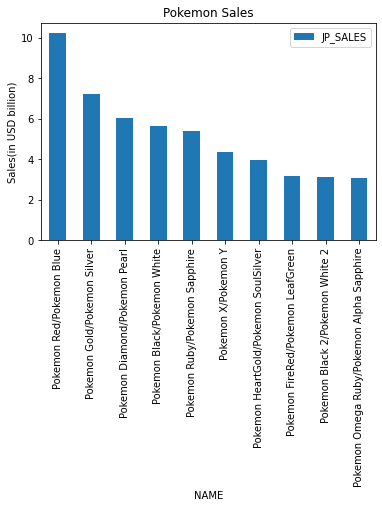

In [99]:
# Checking the sales of Pokemon games
pokemon = spark.sql("""SELECT RANK, NAME, YEAR, JP_SALES
FROM VGS
WHERE NAME LIKE "%Pokemon%"
ORDER BY JP_SALES DESC
LIMIT 10
""")

pokemon.show()
pokemon = pokemon.toPandas()
pokemon.plot(kind = 'bar', x = 'NAME', y = 'JP_SALES', title = 'Pokemon Sales', ylabel = "Sales(in USD billion)")

+----+--------------+----+--------+------------+
|RANK|          NAME|YEAR|PLATFORM|GLOBAL_SALES|
+----+--------------+----+--------+------------+
|  78|       FIFA 16|2015|     PS4|        8.49|
|  83|FIFA Soccer 13|2012|     PS3|        8.24|
| 113|       FIFA 14|2013|     PS3|         6.9|
| 122|       FIFA 12|2011|     PS3|        6.69|
| 125|       FIFA 15|2014|     PS4|        6.59|
| 186|FIFA Soccer 13|2012|    X360|        5.18|
| 200|FIFA Soccer 11|2010|     PS3|        5.08|
| 220|       FIFA 15|2014|     PS3|        4.82|
| 222|       FIFA 17|2016|     PS4|        4.77|
| 257|       FIFA 14|2013|    X360|        4.31|
+----+--------------+----+--------+------------+



<AxesSubplot:title={'center':'FIFA Sales'}, xlabel='NAME', ylabel='Sales(in USD billion)'>

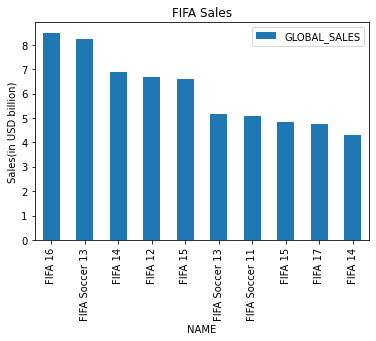

In [101]:
# Checking the highest sales of Fifa games along with the platform
fifa = spark.sql("""SELECT RANK, NAME, YEAR, PLATFORM, GLOBAL_SALES
FROM VGS
WHERE NAME LIKE "%FIFA%"
ORDER BY GLOBAL_SALES DESC
LIMIT 10
""")
fifa.show()
fifa = fifa.toPandas()
fifa.plot(kind = 'bar', x = 'NAME', y = 'GLOBAL_SALES', title = 'FIFA Sales', ylabel = "Sales(in USD billion)")

<AxesSubplot:title={'center':'FIFA 14 - 16 Sales'}, xlabel='NAME', ylabel='Sales(in USD billion)'>

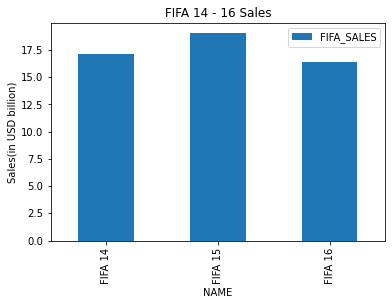

In [102]:
# Checking the highest sales of FIFA games with their sales from each platform combined
fifasales = spark.sql(""" SELECT * 
FROM (SELECT NAME, ROUND(SUM(GLOBAL_SALES),2) AS FIFA_SALES
FROM VGS
WHERE NAME = "FIFA 16"
GROUP BY NAME
UNION
SELECT NAME, ROUND(SUM(GLOBAL_SALES),2)
FROM VGS
WHERE NAME = "FIFA 15"
GROUP BY NAME
UNION
SELECT NAME, ROUND(SUM(GLOBAL_SALES),2)
FROM VGS
WHERE NAME = "FIFA 14"
GROUP BY NAME)
ORDER BY NAME ASC
""").toPandas()
fifasales.plot(kind = "bar", x = "NAME", y = "FIFA_SALES", title = 'FIFA 14 - 16 Sales', ylabel = "Sales(in USD billion)")

In [103]:
# Checking the platforms that is available for FIFA 14 - 16
spark.sql("""SELECT NAME, PLATFORM, GLOBAL_SALES
FROM VGS
WHERE NAME = "FIFA 14"
""").show()

spark.sql("""SELECT NAME, PLATFORM, GLOBAL_SALES
FROM VGS
WHERE NAME = "FIFA 15"
""").show()

spark.sql("""SELECT NAME, PLATFORM, GLOBAL_SALES
FROM VGS
WHERE NAME = "FIFA 16"
""").show()

+-------+--------+------------+
|   NAME|PLATFORM|GLOBAL_SALES|
+-------+--------+------------+
|FIFA 14|     PS3|         6.9|
|FIFA 14|    X360|        4.31|
|FIFA 14|     PS4|         2.9|
|FIFA 14|    XOne|        1.19|
|FIFA 14|     PSV|         0.5|
|FIFA 14|      PC|        0.43|
|FIFA 14|     Wii|        0.43|
|FIFA 14|     3DS|        0.25|
|FIFA 14|     PSP|        0.23|
+-------+--------+------------+

+-------+--------+------------+
|   NAME|PLATFORM|GLOBAL_SALES|
+-------+--------+------------+
|FIFA 15|     PS4|        6.59|
|FIFA 15|     PS3|        4.82|
|FIFA 15|    X360|        3.11|
|FIFA 15|    XOne|        2.15|
|FIFA 15|     PSV|        0.84|
|FIFA 15|     Wii|        0.76|
|FIFA 15|     3DS|        0.45|
|FIFA 15|      PC|         0.3|
+-------+--------+------------+

+-------+--------+------------+
|   NAME|PLATFORM|GLOBAL_SALES|
+-------+--------+------------+
|FIFA 16|     PS4|        8.49|
|FIFA 16|    XOne|        3.23|
|FIFA 16|     PS3|        2.85|
|FIFA 

Conclusion:
- Since Pokemon game has only 1 platform available due to its exclusivity, no other platform can be used to further analysed the series
- Most popular Pokemon games were mostly older games
- Although FIFA 16 was the most popular game, the total sales of FIFA 15 and FIFA 14 were higher than it
- However, the total sales of FIFA 16 was almost on par with the other 2 FIFA games considering FIFA 16 has less platform compared to FIFA 14 and FIFA 15